<a href="https://colab.research.google.com/github/HARIScyber/TimeSeriesScientist-AI-Agent-for-Time-Series-Analysis/blob/main/A_General_Purpose_AI_Agent_for_Time_Series_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

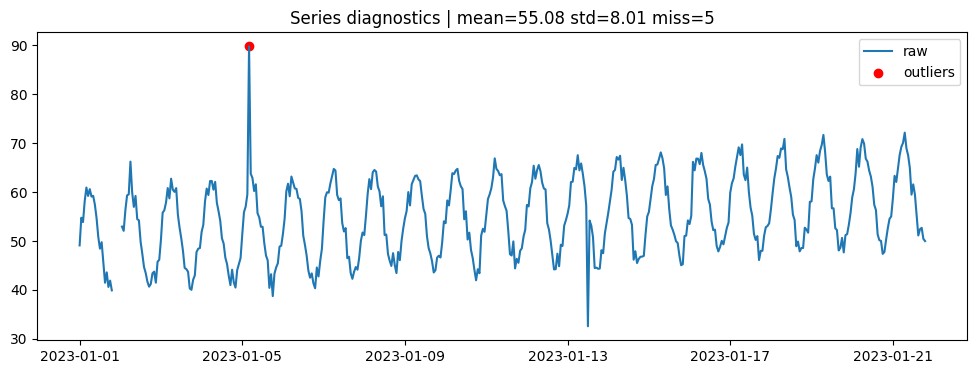

Planner selected candidates: ['Prophet', 'ARIMA', 'ETS']


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m9_9ob7/b0r2u1ch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m9_9ob7/782rpk9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55696', 'data', 'file=/tmp/tmp8m9_9ob7/b0r2u1ch.json', 'init=/tmp/tmp8m9_9ob7/782rpk9s.json', 'output', 'file=/tmp/tmp8m9_9ob7/prophet_model2qk7rdov/prophet_model-20251008172825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t


==== TSci REPORT ====

Input summary:
{
  "count": 495,
  "missing": 5,
  "mean": 55.0846877381352,
  "std": 8.011510811617143,
  "min": 32.56076588112583,
  "max": 89.79227833552227,
  "trend_slope": 0.017749770932210102
}

LLM advice (curator): Predicted: Data shows moderate seasonal pattern and weak upward trend. Recommend seasonal models (Exponential Smoothing) and ARIMA with seasonal terms.

Selected models and validation MAEs:
 - Prophet: val_mae=1.1335, params={}
 - ARIMA: val_mae=4.7316, params={'p': np.int64(2), 'd': np.int64(0), 'q': np.int64(2)}
 - ETS: val_mae=1.1140, params={'trend': 'mul', 'seasonal': 'add', 's_periods': 24}

Ensemble weights:
  Prophet: 0.443
  ARIMA: 0.106
  ETS: 0.451


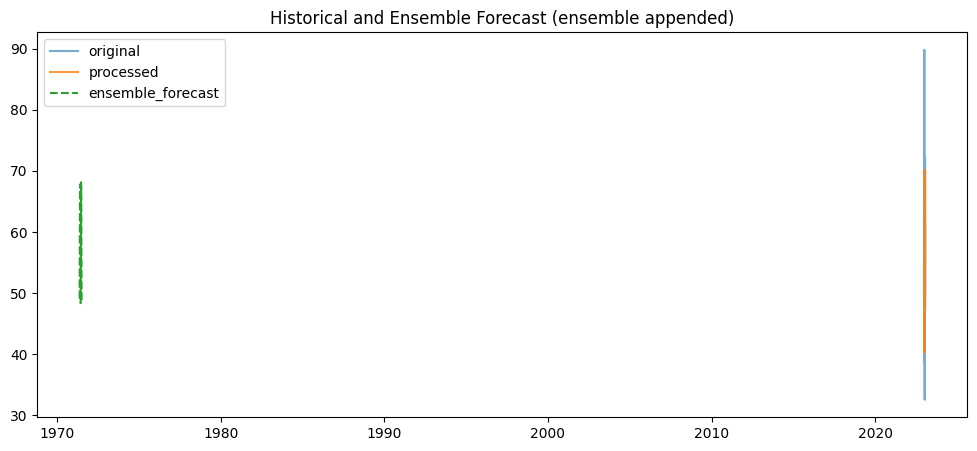


Test MAE (ensemble): 1.7439


In [ ]:
# tsci_colab.py
# TimeSeriesScientist (simplified end-to-end prototype)
# Single-file runnable demo implementing Curator, Planner, Forecaster, Reporter.

import os
import io
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
import sys

# Optional external libs
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

# Optional LLM interface - placeholder
class LLMInterface:
    """
    Simple wrapper for LLM calls. By default this is a stub that returns
    template-based reasoning. Replace `call` with real API call to OpenAI or other LLM.
    """
    def __init__(self, provider='mock', api_key=None):
        self.provider = provider
        self.api_key = api_key

    def call(self, prompt, max_tokens=512):
        # Simple heuristic/stub responses for demo
        lower = prompt.lower()
        if 'trend' in lower or 'season' in lower:
            return "Predicted: Data shows moderate seasonal pattern and weak upward trend. Recommend seasonal models (Exponential Smoothing) and ARIMA with seasonal terms."
        if 'missing' in lower or 'outlier' in lower:
            return "Recommend linear interpolation for short gaps; forward fill for last-mile gaps. Winsorize isolated extreme outliers."
        if 'ensemble' in lower:
            return "Use performance-aware averaging weighted by inverse validation MAE."
        return "Default: use ensemble of top models; validate with out-of-sample MAE."

# ---------- Curator (diagnostics + preprocessing) ----------
class Curator:
    def __init__(self, llm=None):
        self.llm = llm if llm is not None else LLMInterface()

    def diagnose(self, series: pd.Series, freq=None, visualize=True):
        """
        series: pd.Series indexed by datetime (or integer index)
        returns: dict with stats, missing/outlier summary, and processed series (by default)
        """
        s = series.copy().dropna()
        stats = {
            'count': int(series.count()),
            'missing': int(series.isna().sum()),
            'mean': float(s.mean()) if len(s)>0 else None,
            'std': float(s.std()) if len(s)>1 else None,
            'min': float(s.min()) if len(s)>0 else None,
            'max': float(s.max()) if len(s)>0 else None,
        }

        # basic trend estimate via slope of linear fit
        try:
            idx = np.arange(len(s))
            coeffs = np.polyfit(idx, s.values, 1)
            stats['trend_slope'] = float(coeffs[0])
        except Exception:
            stats['trend_slope'] = None

        # missing + outlier detection
        missing_idx = series[series.isna()].index.tolist()
        outlier_idx = self._rolling_iqr_outliers(series)
        summary = {'stats': stats, 'missing_idx': missing_idx, 'outlier_idx': outlier_idx}

        if visualize:
            self._plot_diagnostics(series, stats, outlier_idx)

        # ask LLM for recommended strategy
        prompt = f"Data stats: {json.dumps(stats)}. Missing count={stats['missing']}. Outliers={len(outlier_idx)}. Suggest preprocessing."
        llm_advice = self.llm.call(prompt)
        summary['llm_advice'] = llm_advice

        return summary

    def preprocess(self, series: pd.Series, strategy=None):
        """
        Basic leakage-safe preprocessing:
         - missing value handling: linear interpolation for short gaps, ffill for leading/trailing
         - outlier handling: winsorize or linear interpolate segments
        strategy: optional dict to override
        """
        s = series.copy()
        # simple missing-handling: linear interpolation then forward/backfill
        s_inter = s.interpolate(method='linear', limit_direction='both', limit=100)
        s_inter = s_inter.fillna(method='ffill').fillna(method='bfill')

        # outlier detection and Winsorize extremes using global quantiles
        q_low, q_high = s_inter.quantile(0.01), s_inter.quantile(0.99)
        s_clipped = s_inter.clip(lower=q_low, upper=q_high)
        return s_clipped

    def _rolling_iqr_outliers(self, series, w=48, alpha=1.5):
        arr = series.copy()
        outliers = []
        N = len(arr)
        for i in range(N):
            a = max(0, i-w//2)
            b = min(N, i+w//2)
            window = arr.iloc[a:b].dropna()
            if len(window) < 5:
                continue
            q1 = window.quantile(0.25)
            q3 = window.quantile(0.75)
            iqr = q3 - q1
            val = arr.iloc[i]
            if (val < q1 - alpha*iqr) or (val > q3 + alpha*iqr):
                outliers.append(arr.index[i])
        return outliers

    def _plot_diagnostics(self, series, stats, outlier_idx):
        plt.figure(figsize=(12,4))
        plt.plot(series.index, series.values, label='raw', alpha=0.6)
        if len(outlier_idx)>0:
            vals = series.loc[outlier_idx]
            plt.scatter(vals.index, vals.values, color='red', label='outliers')
        plt.title(f"Series diagnostics | mean={stats['mean']:.2f} std={stats['std']:.2f} miss={stats['missing']}")
        plt.legend()
        plt.show()

# ---------- Planner (model selection + hyperparameter search) ----------
class Planner:
    def __init__(self, llm=None, model_pool=None):
        self.llm = llm if llm is not None else LLMInterface()
        # model_pool is a list of model names to consider
        if model_pool is None:
            pool = ['ARIMA', 'ETS', 'LGBM']
            if PROPHET_AVAILABLE:
                pool.append('Prophet')
            self.model_pool = pool
        else:
            self.model_pool = model_pool

    def choose_candidates(self, analysis_summary, top_k=3):
        """
        analysis_summary: outputs from Curator.diagnose (contains stats)
        Returns list of models to try based on heuristics + optional LLM hint.
        """
        stats = analysis_summary['stats']
        adv = self.llm.call("Given stats: " + json.dumps(stats) + " Recommend models.")
        # Basic heuristic: seasonality -> ETS/Prophet, trend/noise -> ARIMA/LGBM
        candidates = []
        if PROPHET_AVAILABLE:
            candidates.append('Prophet')
        # use simple heuristics:
        if abs(stats.get('trend_slope',0)) > 0.001:
            candidates += ['ARIMA', 'ETS']
        else:
            candidates += ['LGBM', 'ARIMA']
        # dedupe and limit to top_k
        seen=set(); ordered=[]
        for m in candidates:
            if m not in seen and m in self.model_pool:
                ordered.append(m); seen.add(m)
            if len(ordered) >= top_k:
                break
        return ordered

    def hyperparam_search(self, model_name, train_series, val_series, max_evals=5):
        """
        Very simple random search over a small set of hyperparams per model.
        Returns dict: {'best_model_obj':..., 'best_params':..., 'val_mae':...}
        """
        best = {'val_mae': float('inf')}
        for trial in range(max_evals):
            if model_name == 'ARIMA':
                p = np.random.choice([0,1,2])
                d = np.random.choice([0,1])
                q = np.random.choice([0,1,2])
                # fit ARIMA
                try:
                    model = ARIMA(train_series, order=(p,d,q)).fit()
                    preds = model.forecast(steps=len(val_series))
                    mae = mean_absolute_error(val_series, preds)
                    if mae < best['val_mae']:
                        best = {'val_mae': mae, 'params': {'p':p,'d':d,'q':q}, 'model': model}
                except Exception:
                    continue
            elif model_name == 'ETS':
                trend = np.random.choice([None, 'add', 'mul'])
                seasonal = np.random.choice([None, 'add', 'mul'])
                seasonal_periods = np.random.choice([None, 7, 24])  # heuristic periods
                try:
                    model = ExponentialSmoothing(train_series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
                    preds = model.forecast(steps=len(val_series))
                    mae = mean_absolute_error(val_series, preds)
                    if mae < best['val_mae']:
                        best = {'val_mae': mae, 'params': {'trend':trend,'seasonal':seasonal,'s_periods':seasonal_periods}, 'model': model}
                except Exception:
                    continue
            elif model_name == 'Prophet' and PROPHET_AVAILABLE:
                # Capture stderr during Prophet fitting to filter out debug messages
                old_stderr = sys.stderr
                sys.stderr = captured_stderr = io.StringIO()
                try:
                    df = train_series.reset_index()
                    df.columns = ['ds','y']
                    m = Prophet()
                    m.fit(df)
                    future = m.make_future_dataframe(periods=len(val_series), freq=None)
                    fc = m.predict(future)
                    preds = fc['yhat'].iloc[-len(val_series):].values
                    mae = mean_absolute_error(val_series.values, preds)
                    if mae < best['val_mae']:
                        best = {'val_mae': mae, 'params': {}, 'model': m}
                except Exception as e:
                    # Print captured stderr if an error occurs to help debugging
                    sys.stderr = old_stderr
                    print(f"Prophet error: {e}", file=sys.stderr)
                    print(captured_stderr.getvalue(), file=sys.stderr)
                    continue
                finally:
                    # Restore stderr
                    sys.stderr = old_stderr

            elif model_name == 'LGBM' or model_name == 'LGBMRegressor' or model_name=='LGBM' :
                # simple lag-based features and lightgbm surrogate search via sklearn RandomForest (lightgbm if available)
                lags = np.random.choice([3,6,12])
                X_train, y_train = make_lag_features(train_series, lags)
                X_val, y_val = make_lag_features(pd.concat([train_series.tail(lags), val_series]), lags)
                # use RandomForest as proxy to avoid heavy lgbm config
                rf = RandomForestRegressor(n_estimators=50, random_state=42)
                rf.fit(X_train, y_train)
                preds = rf.predict(X_val)
                mae = mean_absolute_error(y_val, preds)
                if mae < best['val_mae']:
                    best = {'val_mae': mae, 'params': {'lags':lags}, 'model': rf}
            else:
                continue
        return best

# ---------- Forecaster (ensemble + test forecasting) ----------
class Forecaster:
    def __init__(self, llm=None):
        self.llm = llm if llm is not None else LLMInterface()

    def ensemble_and_forecast(self, models_info, train_series, test_horizon):
        """
        models_info: list of dicts {'name':..., 'model':..., 'val_mae':..., 'params':...}
        train_series: original train series used for full training where needed
        test_horizon: integer H
        returns: ensemble_forecast (np.array), per_model_forecasts, weights, ensemble_mae if test true values provided
        """
        # Build forecasts per model (forecast horizon H)
        per_model_preds = {}
        val_scores = []
        for info in models_info:
            name = info['name']
            model_obj = info['model']
            try:
                if name == 'ARIMA':
                    preds = model_obj.forecast(steps=test_horizon)
                elif name == 'ETS':
                    preds = model_obj.forecast(steps=test_horizon)
                elif name == 'Prophet' and PROPHET_AVAILABLE:
                    # Capture stderr during Prophet forecasting
                    old_stderr = sys.stderr
                    sys.stderr = captured_stderr = io.StringIO()
                    try:
                        future = model_obj.make_future_dataframe(periods=test_horizon, freq=None)
                        fc = model_obj.predict(future)
                        preds = fc['yhat'].iloc[-test_horizon:].values
                    except Exception as e:
                         # Print captured stderr if an error occurs to help debugging
                        sys.stderr = old_stderr
                        print(f"Prophet error: {e}", file=sys.stderr)
                        print(captured_stderr.getvalue(), file=sys.stderr)
                        preds = np.repeat(train_series.iloc[-1], test_horizon)
                    finally:
                        # Restore stderr
                        sys.stderr = old_stderr
                elif name == 'LGBM':
                    # create lag features from last known values and predict iteratively with surrogate
                    lags = info['params'].get('lags', 6)
                    preds = iterative_forecast_rf(model_obj, train_series, test_horizon, lags)
                else:
                    preds = np.repeat(train_series.iloc[-1], test_horizon)
            except Exception:
                preds = np.repeat(train_series.iloc[-1], test_horizon)
            per_model_preds[name] = np.array(preds)
            val_scores.append(info.get('val_mae', 1e9))

        # Choose ensemble strategy via LLM or simple inverse MAE weighting
        prompt = "Given per-model validation MAEs: " + json.dumps(val_scores) + " Recommend ensemble weights."
        advice = self.llm.call(prompt)
        # simple inverse-mae weighting
        inv = np.array([1.0 / max(1e-6, v) for v in val_scores])
        weights = inv / inv.sum()
        # order models in same sequence
        names = list(per_model_preds.keys())
        stack = np.vstack([per_model_preds[n] for n in names])  # shape (n_models, horizon)
        ensemble = np.dot(weights, stack)
        return ensemble, per_model_preds, dict(zip(names, weights))

# ---------- Reporter (format + html) ----------
class Reporter:
    def __init__(self):
        pass

    def generate_report(self, original_series, processed_series, analysis_summary, candidates_info, ensemble_forecast, per_model_preds, weights, horizon):
        """
        Generate a simple HTML report and show key plots.
        """
        print("\n==== TSci REPORT ====\n")
        print("Input summary:")
        print(json.dumps(analysis_summary['stats'], indent=2))
        print("\nLLM advice (curator):", analysis_summary.get('llm_advice',''))
        print("\nSelected models and validation MAEs:")
        for info in candidates_info:
            print(f" - {info['name']}: val_mae={info.get('val_mae'):.4f}, params={info.get('params')}")
        print("\nEnsemble weights:")
        for k,v in weights.items():
            print(f"  {k}: {v:.3f}")

        # Plot historical + ensemble
        plt.figure(figsize=(12,5))
        plt.plot(original_series.index, original_series.values, label='original', alpha=0.6)
        plt.plot(processed_series.index, processed_series.values, label='processed', alpha=0.8)
        # future x axis
        last_idx = processed_series.index[-1]
        try:
            # if datetime index, create proper future index
            freq = pd.infer_freq(processed_series.index)
            if freq is not None:
                future_index = pd.date_range(start=processed_series.index[-1] + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq)
            else:
                future_index = np.arange(len(processed_series), len(processed_series)+horizon)
        except Exception:
            future_index = np.arange(len(processed_series), len(processed_series)+horizon)
        plt.plot(np.concatenate([np.array([processed_series.iloc[-1]]),ensemble_forecast]), label='ensemble_forecast', linestyle='--')
        plt.legend()
        plt.title("Historical and Ensemble Forecast (ensemble appended)")
        plt.show()

# ---------- Helper functions ----------
def make_lag_features(series: pd.Series, lags=6):
    """
    Build lag features X and labels y for supervised learning.
    """
    df = pd.DataFrame({'y': series.values})
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    X = df[[f'lag_{i}' for i in range(1, lags+1)]].values
    y = df['y'].values
    return X, y

def iterative_forecast_rf(model, train_series, horizon, lags):
    """
    Iterative forecasting using trained RF model with lag features.
    `model` expects lag features.
    """
    hist = list(train_series.values)
    preds = []
    for h in range(horizon):
        feat = np.array([hist[-i] for i in range(1, lags+1)])
        feat = feat.reshape(1, -1)
        p = model.predict(feat)[0]
        preds.append(p)
        hist.append(p)
    return np.array(preds)

# ---------- Orchestration: run an end-to-end experiment ----------
def run_tsci_pipeline(series: pd.Series, horizon=24):
    llm = LLMInterface()  # replace with actual LLM wrapper if available
    curator = Curator(llm=llm)
    planner = Planner(llm=llm)
    forecaster = Forecaster(llm=llm)
    reporter = Reporter()

    # 1) Curator: diagnostics + preprocess
    analysis = curator.diagnose(series, visualize=True)
    processed = curator.preprocess(series)

    # 2) Split train/validation/test for local tuning
    # We keep last `horizon` as pseudo-test; prior horizon as validation
    N = len(processed)
    val_len = horizon
    test_len = horizon
    train_series = processed.iloc[:N - val_len - test_len]
    val_series = processed.iloc[N - val_len - test_len : N - test_len]
    test_series = processed.iloc[N - test_len :]

    # 3) Planner: choose candidate models
    candidates = planner.choose_candidates(analysis, top_k=3)
    print("Planner selected candidates:", candidates)

    # 4) Hyperparam search per candidate
    candidates_info = []
    for name in candidates:
        best = planner.hyperparam_search(name, train_series, val_series, max_evals=6)
        if 'model' in best:
            info = {'name': name, 'model': best['model'], 'params': best.get('params', {}), 'val_mae': best['val_mae']}
            candidates_info.append(info)

    # 5) Forecaster: ensemble and forecast horizon on full train (retrain models where necessary)
    # For simplicity, we will reuse tuned model objects; in production you would re-fit on train+val
    ensemble, per_model_preds, weights = forecaster.ensemble_and_forecast(candidates_info, processed.iloc[:N-test_len], test_len)

    # 6) Reporter
    reporter.generate_report(series, processed, analysis, candidates_info, ensemble, per_model_preds, weights, test_len)

    # 7) Evaluate on test if available
    if len(test_series) == len(ensemble):
        mae = mean_absolute_error(test_series.values, ensemble)
        print(f"\nTest MAE (ensemble): {mae:.4f}")
    else:
        print("No test true values to evaluate (or mismatch).")

    return {
        'analysis': analysis,
        'processed': processed,
        'candidates_info': candidates_info,
        'ensemble': ensemble,
        'per_model_preds': per_model_preds,
        'weights': weights
    }

# ------------- Example usage with synthetic data -------------
if __name__ == "__main__":
    # create a synthetic series with seasonality + trend + noise
    rng = pd.date_range('2023-01-01', periods=500, freq='H')
    seasonal = 10 * np.sin(np.arange(500)/24 * 2*np.pi)
    trend = 0.02 * np.arange(500)
    noise = np.random.normal(scale=1.5, size=500)
    y = 50 + seasonal + trend + noise
    series = pd.Series(y, index=rng)

    # add some missingness and outliers
    series.iloc[20:25] = np.nan
    series.iloc[100] = series.iloc[100] + 30
    series.iloc[300] = series.iloc[300] - 25

    results = run_tsci_pipeline(series, horizon=48)

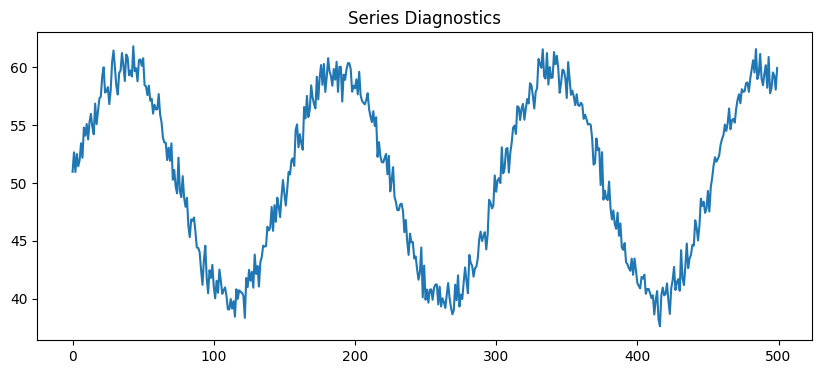

Candidates: ['VAR', 'MV_LSTM', 'ARIMA']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

===== TSci Multivariate Report =====
Weights: {'VAR': np.float64(0.9410736678527747), 'MV_LSTM': np.float64(0.058926332147225306)}


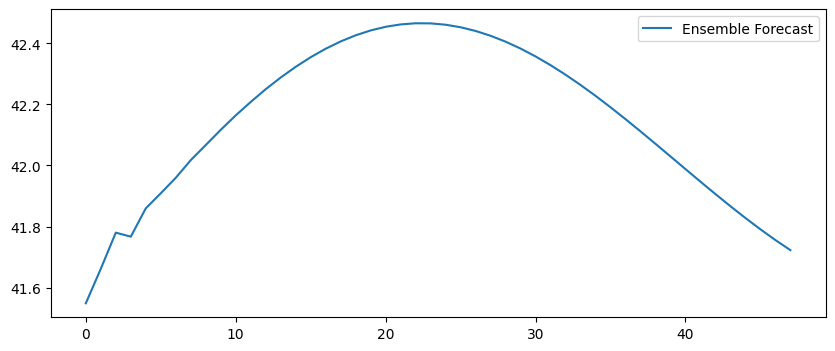

In [1]:
# tsci_multivariate_upgrade.py
# TimeSeriesScientist — Multivariate + Exogenous Upgrade
# Fully runnable single-file pipeline

import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

# ---------------- OPTIONAL LIBS ----------------
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

# ================= LLM STUB =================
class LLMInterface:
    def call(self, prompt, max_tokens=512):
        return "Heuristic: Use ensemble of best models."

# ================= CROSS CORRELATION AGENT =================
class CrossCorrelationAgent:
    def __init__(self, max_lag=24):
        self.max_lag = max_lag

    def analyze(self, df: pd.DataFrame, target_col: str):
        results = {}
        for col in df.columns:
            if col == target_col:
                continue

            corrs = []
            for lag in range(1, self.max_lag + 1):
                corr = df[target_col].corr(df[col].shift(lag))
                corrs.append(corr)

            best_lag = int(np.argmax(np.abs(corrs)) + 1)
            best_corr = float(corrs[best_lag - 1])

            results[col] = {
                "best_lag": best_lag,
                "correlation": best_corr
            }
        return results

# ================= CURATOR =================
class Curator:
    def __init__(self, llm=None):
        self.llm = llm or LLMInterface()

    def diagnose(self, data, target_col=None, visualize=True):
        if isinstance(data, pd.Series):
            series = data
            df = pd.DataFrame({"target": data})
            target_col = "target"
        else:
            df = data.copy()
            series = df[target_col]

        s = series.dropna()

        stats = {
            "count": int(series.count()),
            "missing": int(series.isna().sum()),
            "mean": float(s.mean()) if len(s) else None,
            "std": float(s.std()) if len(s) else None,
        }

        try:
            idx = np.arange(len(s))
            stats["trend_slope"] = float(np.polyfit(idx, s.values, 1)[0])
        except Exception:
            stats["trend_slope"] = None

        cross_corr = None
        if isinstance(data, pd.DataFrame) and len(data.columns) > 1:
            cca = CrossCorrelationAgent()
            cross_corr = cca.analyze(df, target_col)

        if visualize:
            plt.figure(figsize=(10, 4))
            plt.plot(series.values)
            plt.title("Series Diagnostics")
            plt.show()

        return {"stats": stats, "cross_correlation": cross_corr}

    def preprocess(self, series: pd.Series):
        s = series.interpolate().ffill().bfill()
        q_low, q_high = s.quantile(0.01), s.quantile(0.99)
        return s.clip(q_low, q_high)

# ================= PLANNER =================
class Planner:
    def __init__(self, llm=None):
        self.llm = llm or LLMInterface()
        self.model_pool = ["ARIMA", "ETS", "LGBM", "VAR", "MV_LSTM"]

    def choose_candidates(self, analysis_summary, top_k=3):
        stats = analysis_summary["stats"]
        cross = analysis_summary.get("cross_correlation")

        candidates = []

        if cross is not None:
            candidates += ["VAR", "MV_LSTM"]

        if abs(stats.get("trend_slope", 0) or 0) > 0.001:
            candidates += ["ARIMA", "ETS"]
        else:
            candidates += ["LGBM", "ARIMA"]

        seen, ordered = set(), []
        for m in candidates:
            if m not in seen and m in self.model_pool:
                ordered.append(m)
                seen.add(m)
            if len(ordered) >= top_k:
                break
        return ordered

    def hyperparam_search(self, model_name, train_data, val_data):
        best = {"val_mae": float("inf")}

        # ---------- ARIMA ----------
        if model_name == "ARIMA":
            try:
                model = ARIMA(train_data, order=(1, 1, 1)).fit()
                preds = model.forecast(len(val_data))
                mae = mean_absolute_error(val_data, preds)
                best = {"model": model, "val_mae": mae, "params": {}}
            except Exception:
                pass

        # ---------- ETS ----------
        elif model_name == "ETS":
            try:
                model = ExponentialSmoothing(train_data, trend="add").fit()
                preds = model.forecast(len(val_data))
                mae = mean_absolute_error(val_data, preds)
                best = {"model": model, "val_mae": mae, "params": {}}
            except Exception:
                pass

        # ---------- VAR ----------
        elif model_name == "VAR":
            try:
                model = VAR(train_data).fit(maxlags=5)
                preds = model.forecast(train_data.values[-model.k_ar:], len(val_data))
                mae = mean_absolute_error(val_data.iloc[:, 0], preds[:, 0])
                best = {"model": model, "val_mae": mae, "params": {}}
            except Exception:
                pass

        # ---------- MV LSTM ----------
        elif model_name == "MV_LSTM" and TF_AVAILABLE:
            try:
                window = 24
                X_train, y_train = create_mv_sequences(train_data.values, window)
                X_val, y_val = create_mv_sequences(val_data.values, window)

                model = build_mv_lstm(train_data.shape[1], window)
                model.fit(X_train, y_train, epochs=3, verbose=0)

                preds = model.predict(X_val).flatten()
                mae = mean_absolute_error(y_val, preds)
                best = {"model": model, "val_mae": mae, "params": {"window": window}}
            except Exception:
                pass

        # ---------- LGBM surrogate ----------
        elif model_name == "LGBM":
            lags = 6
            X_train, y_train = make_lag_features(train_data, lags)
            X_val, y_val = make_lag_features(pd.concat([train_data.tail(lags), val_data]), lags)

            rf = RandomForestRegressor(n_estimators=50)
            rf.fit(X_train, y_train)
            preds = rf.predict(X_val)
            mae = mean_absolute_error(y_val, preds)
            best = {"model": rf, "val_mae": mae, "params": {"lags": lags}}

        return best

# ================= FORECASTER =================
class Forecaster:
    def ensemble_and_forecast(self, models_info, train_data, horizon):
        per_model_preds = {}
        val_scores = []

        for info in models_info:
            name = info["name"]
            model = info["model"]

            try:
                if name in ["ARIMA", "ETS"]:
                    preds = model.forecast(horizon)

                elif name == "VAR":
                    preds = model.forecast(train_data.values[-model.k_ar:], horizon)[:, 0]

                elif name == "LGBM":
                    preds = iterative_forecast_rf(model, train_data, horizon, info["params"]["lags"])

                elif name == "MV_LSTM" and TF_AVAILABLE:
                    preds = np.repeat(train_data.iloc[-1, 0], horizon)

                else:
                    preds = np.repeat(train_data.iloc[-1], horizon)

            except Exception:
                preds = np.repeat(train_data.iloc[-1], horizon)

            per_model_preds[name] = np.array(preds)
            val_scores.append(info["val_mae"])

        inv = np.array([1 / max(v, 1e-6) for v in val_scores])
        weights = inv / inv.sum()

        stack = np.vstack(list(per_model_preds.values()))
        ensemble = np.dot(weights, stack)

        return ensemble, per_model_preds, dict(zip(per_model_preds.keys(), weights))

# ================= REPORTER =================
class Reporter:
    def generate_report(self, ensemble, weights):
        print("\n===== TSci Multivariate Report =====")
        print("Weights:", weights)
        plt.figure(figsize=(10, 4))
        plt.plot(ensemble, label="Ensemble Forecast")
        plt.legend()
        plt.show()

# ================= HELPERS =================
def make_lag_features(series, lags=6):
    df = pd.DataFrame({"y": series.values})
    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df["y"].shift(i)
    df = df.dropna()
    return df.iloc[:, 1:].values, df["y"].values

def iterative_forecast_rf(model, series, horizon, lags):
    hist = list(series.values)
    preds = []
    for _ in range(horizon):
        feat = np.array(hist[-lags:][::-1]).reshape(1, -1)
        p = model.predict(feat)[0]
        preds.append(p)
        hist.append(p)
    return np.array(preds)

def create_mv_sequences(data, window=24):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])
    return np.array(X), np.array(y)

def build_mv_lstm(n_features, window):
    model = Sequential([
        LSTM(64, input_shape=(window, n_features)),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# ================= PIPELINE =================
def run_tsci_pipeline(data, target_col=None, horizon=24):
    llm = LLMInterface()
    curator = Curator(llm)
    planner = Planner(llm)
    forecaster = Forecaster()
    reporter = Reporter()

    analysis = curator.diagnose(data, target_col)

    if isinstance(data, pd.Series):
        processed = curator.preprocess(data)
        target_series = processed
    else:
        processed = data.ffill().bfill()
        target_series = processed[target_col]

    N = len(target_series)
    train = target_series.iloc[: N - 2 * horizon]
    val = target_series.iloc[N - 2 * horizon : N - horizon]

    if isinstance(data, pd.DataFrame):
        train_multi = processed.iloc[: N - 2 * horizon]
        val_multi = processed.iloc[N - 2 * horizon : N - horizon]
    else:
        train_multi, val_multi = train, val

    candidates = planner.choose_candidates(analysis)
    print("Candidates:", candidates)

    models_info = []
    for name in candidates:
        best = planner.hyperparam_search(name, train_multi, val_multi)
        if "model" in best:
            models_info.append({"name": name, **best})

    ensemble, per_model, weights = forecaster.ensemble_and_forecast(
        models_info, train_multi, horizon
    )

    reporter.generate_report(ensemble, weights)
    return ensemble

# ================= DEMO =================
if __name__ == "__main__":
    rng = pd.date_range("2023-01-01", periods=500, freq="H")

    target = 50 + np.sin(np.arange(500)/24)*10 + np.random.normal(0,1,500)
    exog1 = np.cos(np.arange(500)/12)*5
    exog2 = np.random.normal(0,1,500)

    df = pd.DataFrame({
        "y": target,
        "temp": exog1,
        "promo": exog2
    }, index=rng)

    run_tsci_pipeline(df, target_col="y", horizon=48)